In [1]:
import numpy as np
from gymnasium.wrappers import TimeLimit

from src.environments import ea
from src.eval import Study
from src.eval.eval_rl_v3_sim import generate_trials
from src.trial import Trial
from src.wrappers import RecordEpisode

In [2]:
def evaluate_optimizer(
    config: dict,
    write_data: bool = True,
    seed: int | None = None,
    evaluation_name: str = "unnamed",
) -> None:
    trials = generate_trials(num=20, seed=seed)

    for i, trial in enumerate(trials):
        evaluate_on_trial(i, trial, config, write_data, evaluation_name)


def evaluate_on_trial(
    trial_index: int,
    trial: Trial,
    config: dict,
    write_data: bool = True,
    evaluation_name: str = "unnamed",
) -> None:
    # Create the environment
    env = ea.TransverseTuning(
        backend="cheetah",
        backend_args={
            "incoming_mode": trial.incoming_beam,
            "max_misalignment": 5e-4,
            "misalignment_mode": trial.misalignments,
            "simulate_finite_screen": False,
        },
        action_mode="direct",
        magnet_init_mode=config["magnet_init_mode"],
        max_quad_setting=config["max_quad_setting"],
        target_beam_mode=np.zeros(4),
        target_threshold=None,
        threshold_hold=5,
        clip_magnets=True,
    )
    env = TimeLimit(env, 150)
    if write_data:
        env = RecordEpisode(
            env,
            save_dir=(f"data/{evaluation_name}/problem_{trial_index:03d}"),
        )

    # Actual optimisation
    observation, info = env.reset()
    done = False
    while not done:
        action = np.zeros(5)
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    env.close()

In [3]:
evaluation_name = "just_zeros"

evaluate_optimizer(
    config={"magnet_init_mode": "random", "max_quad_setting": 30},
    write_data=True,
    seed=42,
    evaluation_name=evaluation_name,
)

Overwriting existing data recordings at /Users/jankaiser/Documents/DESY/rl4aa25-tutorial/data/just_zeros/problem_000 folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.
Overwriting existing data recordings at /Users/jankaiser/Documents/DESY/rl4aa25-tutorial/data/just_zeros/problem_001 folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.
Overwriting existing data recordings at /Users/jankaiser/Documents/DESY/rl4aa25-tutorial/data/just_zeros/problem_002 folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.
Overwriting existing data recordings at /Users/jankaiser/Documents/DESY/rl4aa25-tutorial/data/just_zeros/problem_003 folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.
Overwriting existing data recordings at /Users/jankaiser/Documents/DESY/rl4aa25-tutorial/data/just_zeros/problem_004 folder. Specify a different `save_d

In [4]:
study = Study.load(f"data/{evaluation_name}")

In [5]:
print(f"Final MAE: {study.median_final_mae() * 1e6:.0f} μm")
print(f"Steps to convergence: {study.median_steps_to_convergence(threshold=4e-5)}")
print(f"Sum of magnet changes: {study.median_sum_of_normalized_magnet_changes():.2f}")

Final MAE: 342 μm
Steps to convergence: 1.0
Sum of magnet changes: 2.49


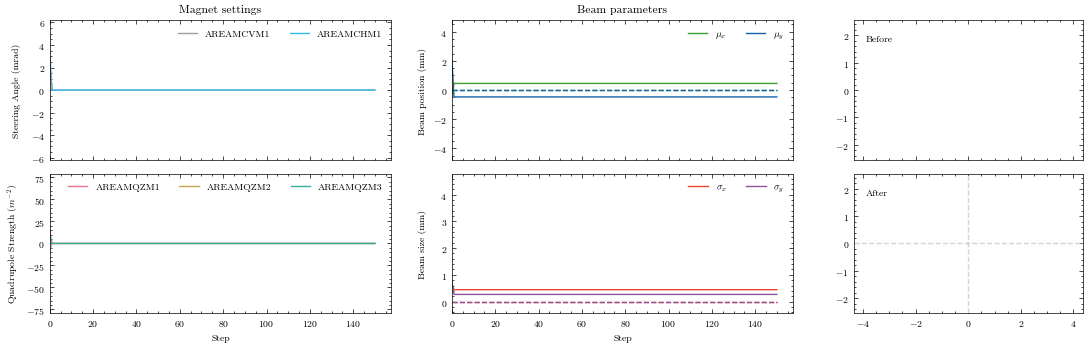

In [6]:
_ = study.episodes[2].plot_summary()